In [1]:
import cmath
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from library.plots import plot_surface, plot_heatmap
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import pickle
# use style from seaborn
# plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 200

In [67]:
# diffractio distances
distances = [10, 100, 250, 500, 1_000, 2000, 3_000]

# load data from pickle intensity_{distance}.pkl
intensities = {}
for distance in distances:
    with open(f"intensity_{distance}.pkl", "rb") as f:
        intensities = pickle.load(f)

In [600]:
def hist_at_time(distance_slit, particle_velocity, barrier_y, particle_positions_history, time_step, x_bins, total_time, range):

    time_to_reach_distance = distance_slit / particle_velocity
    time_to_reach_barrier = abs(barrier_y) / particle_velocity
    if distance_slit > barrier_y:
        raise ValueError("Distance to slit must be greater than barrier_y.")
    # Adjust the time_for_histogram based on the barrier_y position
    total_time_to_reach_distance = time_to_reach_distance + time_to_reach_barrier
    
    if total_time_to_reach_distance > total_time:
        raise ValueError("Time to reach distance must be less than total_time.")
    # Calculate the closest time index for the adjusted time_for_histogram
    closest_time_index = int(total_time_to_reach_distance / time_step)
    
    # Ensure the index is within bounds
    if closest_time_index >= len(particle_positions_history):
        print("Adjusted time for histogram exceeds the total time of the simulation.")
        return
    
    # Extract particle positions at the closest time index
    particle_positions_at_time = particle_positions_history[closest_time_index]
    
    # Extract the x-positions at this time
    x_positions_at_time = particle_positions_at_time[:, 0]
    hist, bins = np.histogram(x_positions_at_time, bins=x_bins, range=range)
    return hist, bins


# 2

In [762]:
def calculate_distorted_gravitational_forces(distance_magnitudes, unit_vectors, G, alpha, k, og_grav=1, particle_masses=None):
    if particle_masses is not None:
        force_mags = G * particle_masses[:, np.newaxis] / distance_magnitudes ** 2
    else:
        force_mags = G / distance_magnitudes ** 2

    force_mags *= (og_grav + alpha * np.sin(k * distance_magnitudes))
    net_forces = np.sum(force_mags[:, :, np.newaxis] * unit_vectors, axis=1)
    return net_forces


In [769]:
# Initialize constants
G = 0.08  # Gravitational constant (m^3/kg/s^2)
# G = 0.006  # Gravitational constant (m^3/kg/s^2)
alpha = 1.0  # Amplitude of wave-like distortion
lambda_ = 0.05  # Wavelength (m)
og_grav = 0
k = 2 * np.pi / lambda_  # Wave number
# k = 488
# k = 623.8
# k = 314
# k = 0
time_step = 0.001  # Time step for numerical integration (s)
total_time = 1.0  # Total simulation time (s)
num_steps = int(total_time / time_step)  # Number of time steps
epsilon = 0.0  # Softening parameter for gravitational force (m)

# Update constants and initial conditions based on new requirements
x_scaler = 1.0
x_range = 1.0 * x_scaler
bins_x = 500
barrier_start_x1 = 0.20 * x_scaler
# barrier_end_x1 = 0.45 * x_scaler
# barrier_start_x2 = 0.55 * x_scaler
barrier_end_x2 = 0.8 * x_scaler
initial_velocity_magnitude = 3
particle_mass = 1


# Re-initialize particle positions and masses
# Initialize particle positions and masses
num_particles = 10_000

# Update particle positions based on new requirements
particle_start_x1 = barrier_start_x1 + epsilon
particle_end_x2 = barrier_end_x2 - epsilon

# Initialize masses for the particles
particle_masses = np.ones(num_particles) * particle_mass

# Re-initialize barrier
barrier_y = 1
barrier_nodes_x = np.array(
    [barrier_start_x1, barrier_end_x2]
)

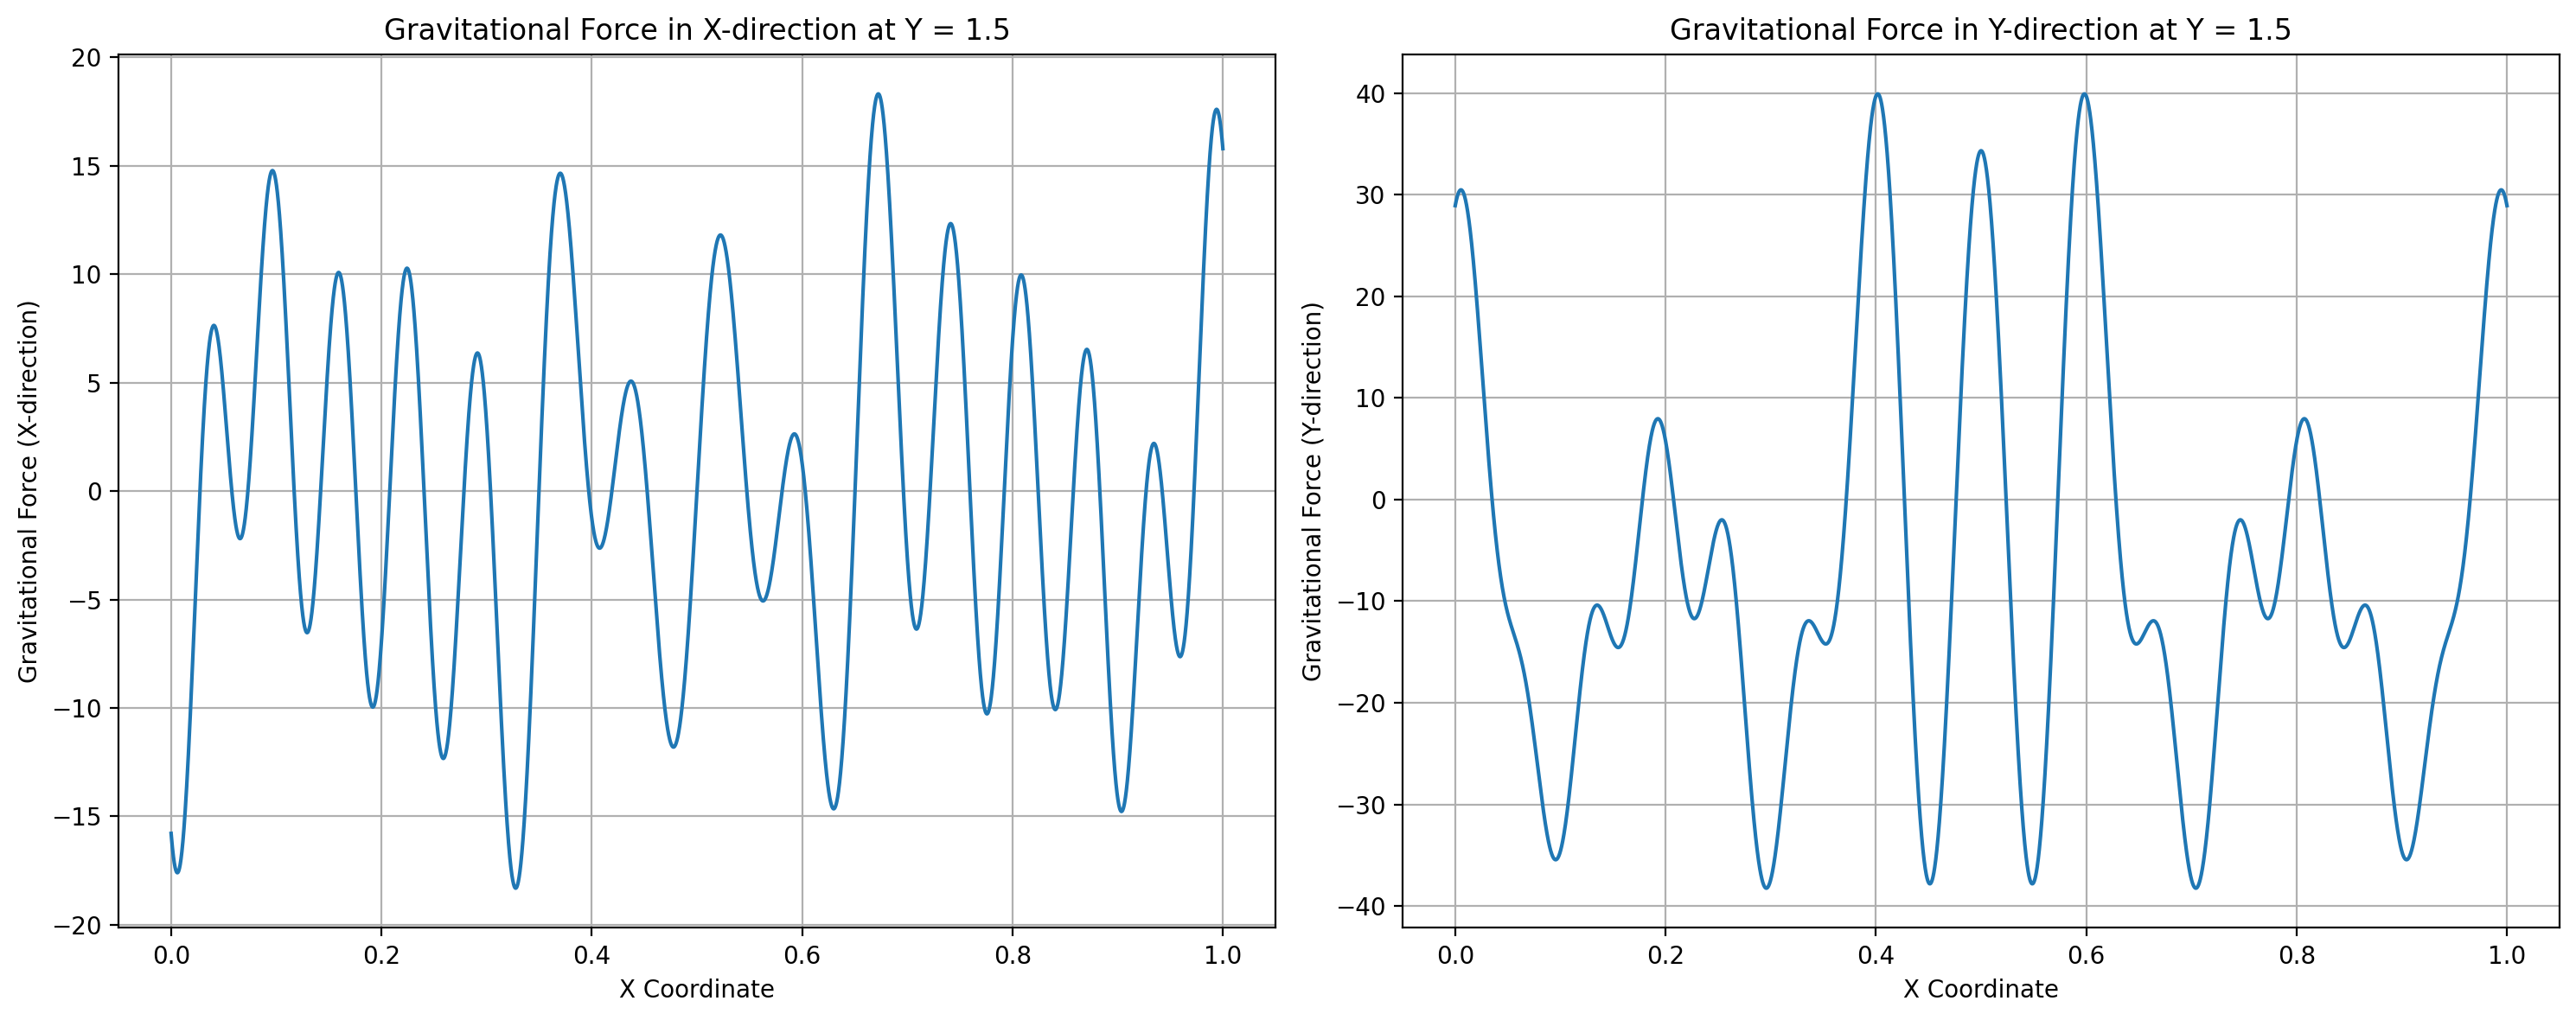

In [770]:
# Initialize the x-coordinates for which we want to calculate the gravitational force
x_coordinates_to_evaluate = np.linspace(0, x_range, 5000)
y_coordinate = 1.5 # y-coordinate is set to 0

# Initialize an array to store the gravitational forces at each x-coordinate
gravitational_forces = np.zeros((len(x_coordinates_to_evaluate), 2))

# Expand dimensions for broadcasting
x_coordinates_expanded = np.expand_dims(
    np.array(
        [x_coordinates_to_evaluate, [y_coordinate] * len(x_coordinates_to_evaluate)]
    ).T,
    axis=1,
)
barrier_nodes_expanded = np.expand_dims(
    np.array([barrier_nodes_x, [barrier_y] * len(barrier_nodes_x)]).T, axis=0
)

# Calculate distance vectors and their magnitudes
distance_vectors = barrier_nodes_expanded - x_coordinates_expanded
distance_magnitudes = np.linalg.norm(distance_vectors, axis=2)

# Calculate unit vectors
unit_vectors = distance_vectors / np.expand_dims(distance_magnitudes, axis=2)

gravitational_forces = calculate_distorted_gravitational_forces(
    distance_magnitudes, unit_vectors, G, alpha, k, og_grav
)


# Plot the gravitational force in both x and y directions
plt.figure(figsize=(15, 6))

# Gravitational force in the x-direction
plt.subplot(1, 2, 1)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 0])
plt.xlabel("X Coordinate")
plt.ylabel("Gravitational Force (X-direction)")
plt.title(f"Gravitational Force in X-direction at Y = {y_coordinate}")
# limit y to y average
# plt.ylim(-gravitational_forces[:, 0].max() / 10000, gravitational_forces[:, 0].max() / 10000)
plt.grid(True)

# Gravitational force in the y-direction
plt.subplot(1, 2, 2)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 1])
plt.xlabel("X Coordinate")
plt.ylabel("Gravitational Force (Y-direction)")
plt.title(f"Gravitational Force in Y-direction at Y = {y_coordinate}")
plt.grid(True)

plt.tight_layout()
plt.show()

In [771]:
# Initialize particle positions for the two regions
particle_positions1 = np.linspace(
    particle_start_x1, particle_end_x2, num_particles
).reshape(-1, 1)

# Combine the positions and add the y-component (which is zero)
particle_positions1 = np.hstack([particle_positions1, np.zeros((num_particles, 1))])
particle_positions = np.vstack([particle_positions1])


# Re-initialize velocity (all particles now have initial velocity directed towards the barrier)
particle_velocities = np.zeros((num_particles, 2))
particle_velocities[
    :, 1
] = initial_velocity_magnitude
initial_velocities = particle_velocities.copy()

# Re-run the simulation loop
particle_positions_history = [particle_positions.copy()]  # Reset history

for step in tqdm(range(num_steps)):
    net_forces = np.zeros((num_particles, 2))

    # Calculate distances from all particles to all nodes at once
    particle_positions_expanded = np.expand_dims(particle_positions, axis=1)
    barrier_nodes_expanded = np.expand_dims(
        np.array([barrier_nodes_x, [barrier_y] * len(barrier_nodes_x)]).T, axis=0
    )

    distance_vectors = barrier_nodes_expanded - particle_positions_expanded
    distance_magnitudes = np.linalg.norm(distance_vectors, axis=2)

    # Calculate unit vectors
    unit_vectors = distance_vectors / np.expand_dims(distance_magnitudes, axis=2)

    net_forces = calculate_distorted_gravitational_forces(
        distance_magnitudes, unit_vectors, G, alpha, k, og_grav, particle_masses
    )

    # Update particle velocities and positions
    particle_velocities += net_forces * time_step
    # max_velocity_magnitude = np.linalg.norm(initial_velocities, axis=1)
    # current_velocity_magnitude = np.linalg.norm(particle_velocities, axis=1)
    # scaling_factor = np.where(
    #     current_velocity_magnitude > max_velocity_magnitude,
    #     max_velocity_magnitude / current_velocity_magnitude,
    #     1,
    # )
    # particle_velocities *= scaling_factor[:, np.newaxis]
    particle_positions += particle_velocities * time_step

    # Store the updated positions for visualization
    particle_positions_history.append(particle_positions.copy())


# Convert the history to a numpy array for easier indexing
particle_positions_history = np.array(particle_positions_history)

max_y = total_time * initial_velocity_magnitude

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 876.90it/s]


In [772]:
max_distance = total_time * initial_velocity_magnitude
print(f'max reachable distance: {max_distance}')
print(f'{barrier_y = }')
hist, bins = hist_at_time(
    -barrier_y,
    initial_velocity_magnitude,
    barrier_y,
    particle_positions_history,
    time_step,
    bins_x,
    total_time,
    [0, x_range],
)
particles_per_x = hist.max()
print(f"{particles_per_x = }")

max reachable distance: 3.0
barrier_y = 1
particles_per_x = 34


In [773]:
quantum_distance = distances[0]
newtonian_distance = quantum_distance / 1000
# plot histogram line a filled area
hist, bins = hist_at_time(
    newtonian_distance,
    initial_velocity_magnitude,
    barrier_y,
    particle_positions_history,
    time_step,
    bins_x,
    total_time,
    [0, x_range],
)

In [774]:
# Create the subplots
fig = go.Figure()

# Add traces for each plot
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, x_range, bins_x),
        y=hist / particles_per_x,
        mode="lines",
        name="Newtonian Distribution",
    )
)

fig.add_trace(
    go.Scatter(
        x=np.linspace(0, x_range, bins_x),
        y=intensities[quantum_distance],
        mode="lines",
        name="Quantum Distribution",
        xaxis="x2",
        yaxis="y2",
    )
)

# Update layout to create side-by-side subplots
fig.update_layout(
    xaxis=dict(domain=[0, 0.49]),
    xaxis2=dict(domain=[0.51, 1]),
    yaxis2=dict(anchor="x2"),
    title="Comparison of Newtonian and Quantum Distributions",
)
#plotly dark theme
fig.update_layout(template="plotly_dark")
# transparent background
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()

In [722]:

fig = px.line(x=bins[:-1], y=hist/particles_per_x, range_x=[0, x_range])
fig.update_layout(template="plotly_dark")
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()

In [723]:
fig = px.line(x=np.linspace(0, x_range, bins_x), y=intensities[quantum_distance], range_x=[0, x_range])
fig.update_layout(template="plotly_dark")
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()

In [724]:
import plotly.graph_objects as go
import numpy as np

# particle_positions_history = particle_positions_history[:1000, :, :]
max_y = particle_positions_history[:, :, 1].max()

# Define the bins for x and y coordinates
x_bins = np.linspace(0, x_range, 100)
y_bins = np.linspace(
    0,
    total_time * initial_velocity_magnitude,
    (particle_positions_history.shape[0] - 1) ,
)

flattened_x_positions = particle_positions_history[:, :, 0].flatten()
flattened_y_positions = particle_positions_history[:, :, 1].flatten()
H, x_edges, y_edges = np.histogram2d(
    flattened_x_positions, flattened_y_positions, bins=[x_bins, y_bins], density=False
)

# transpose T and inverse in y
H = H.T
# H = H[::-1]

# Create meshgrid for x and y_steps
x_mesh, y_mesh = np.meshgrid((x_bins[:-1] + x_bins[1:]) / 2, num_steps)

In [725]:
plot_surface(pd.DataFrame(H), x_mesh, y_mesh, "plotly_dark", {})

In [716]:
plot_heatmap(pd.DataFrame(H))

100%|██████████| 10000/10000 [00:01<00:00, 5487.14it/s]


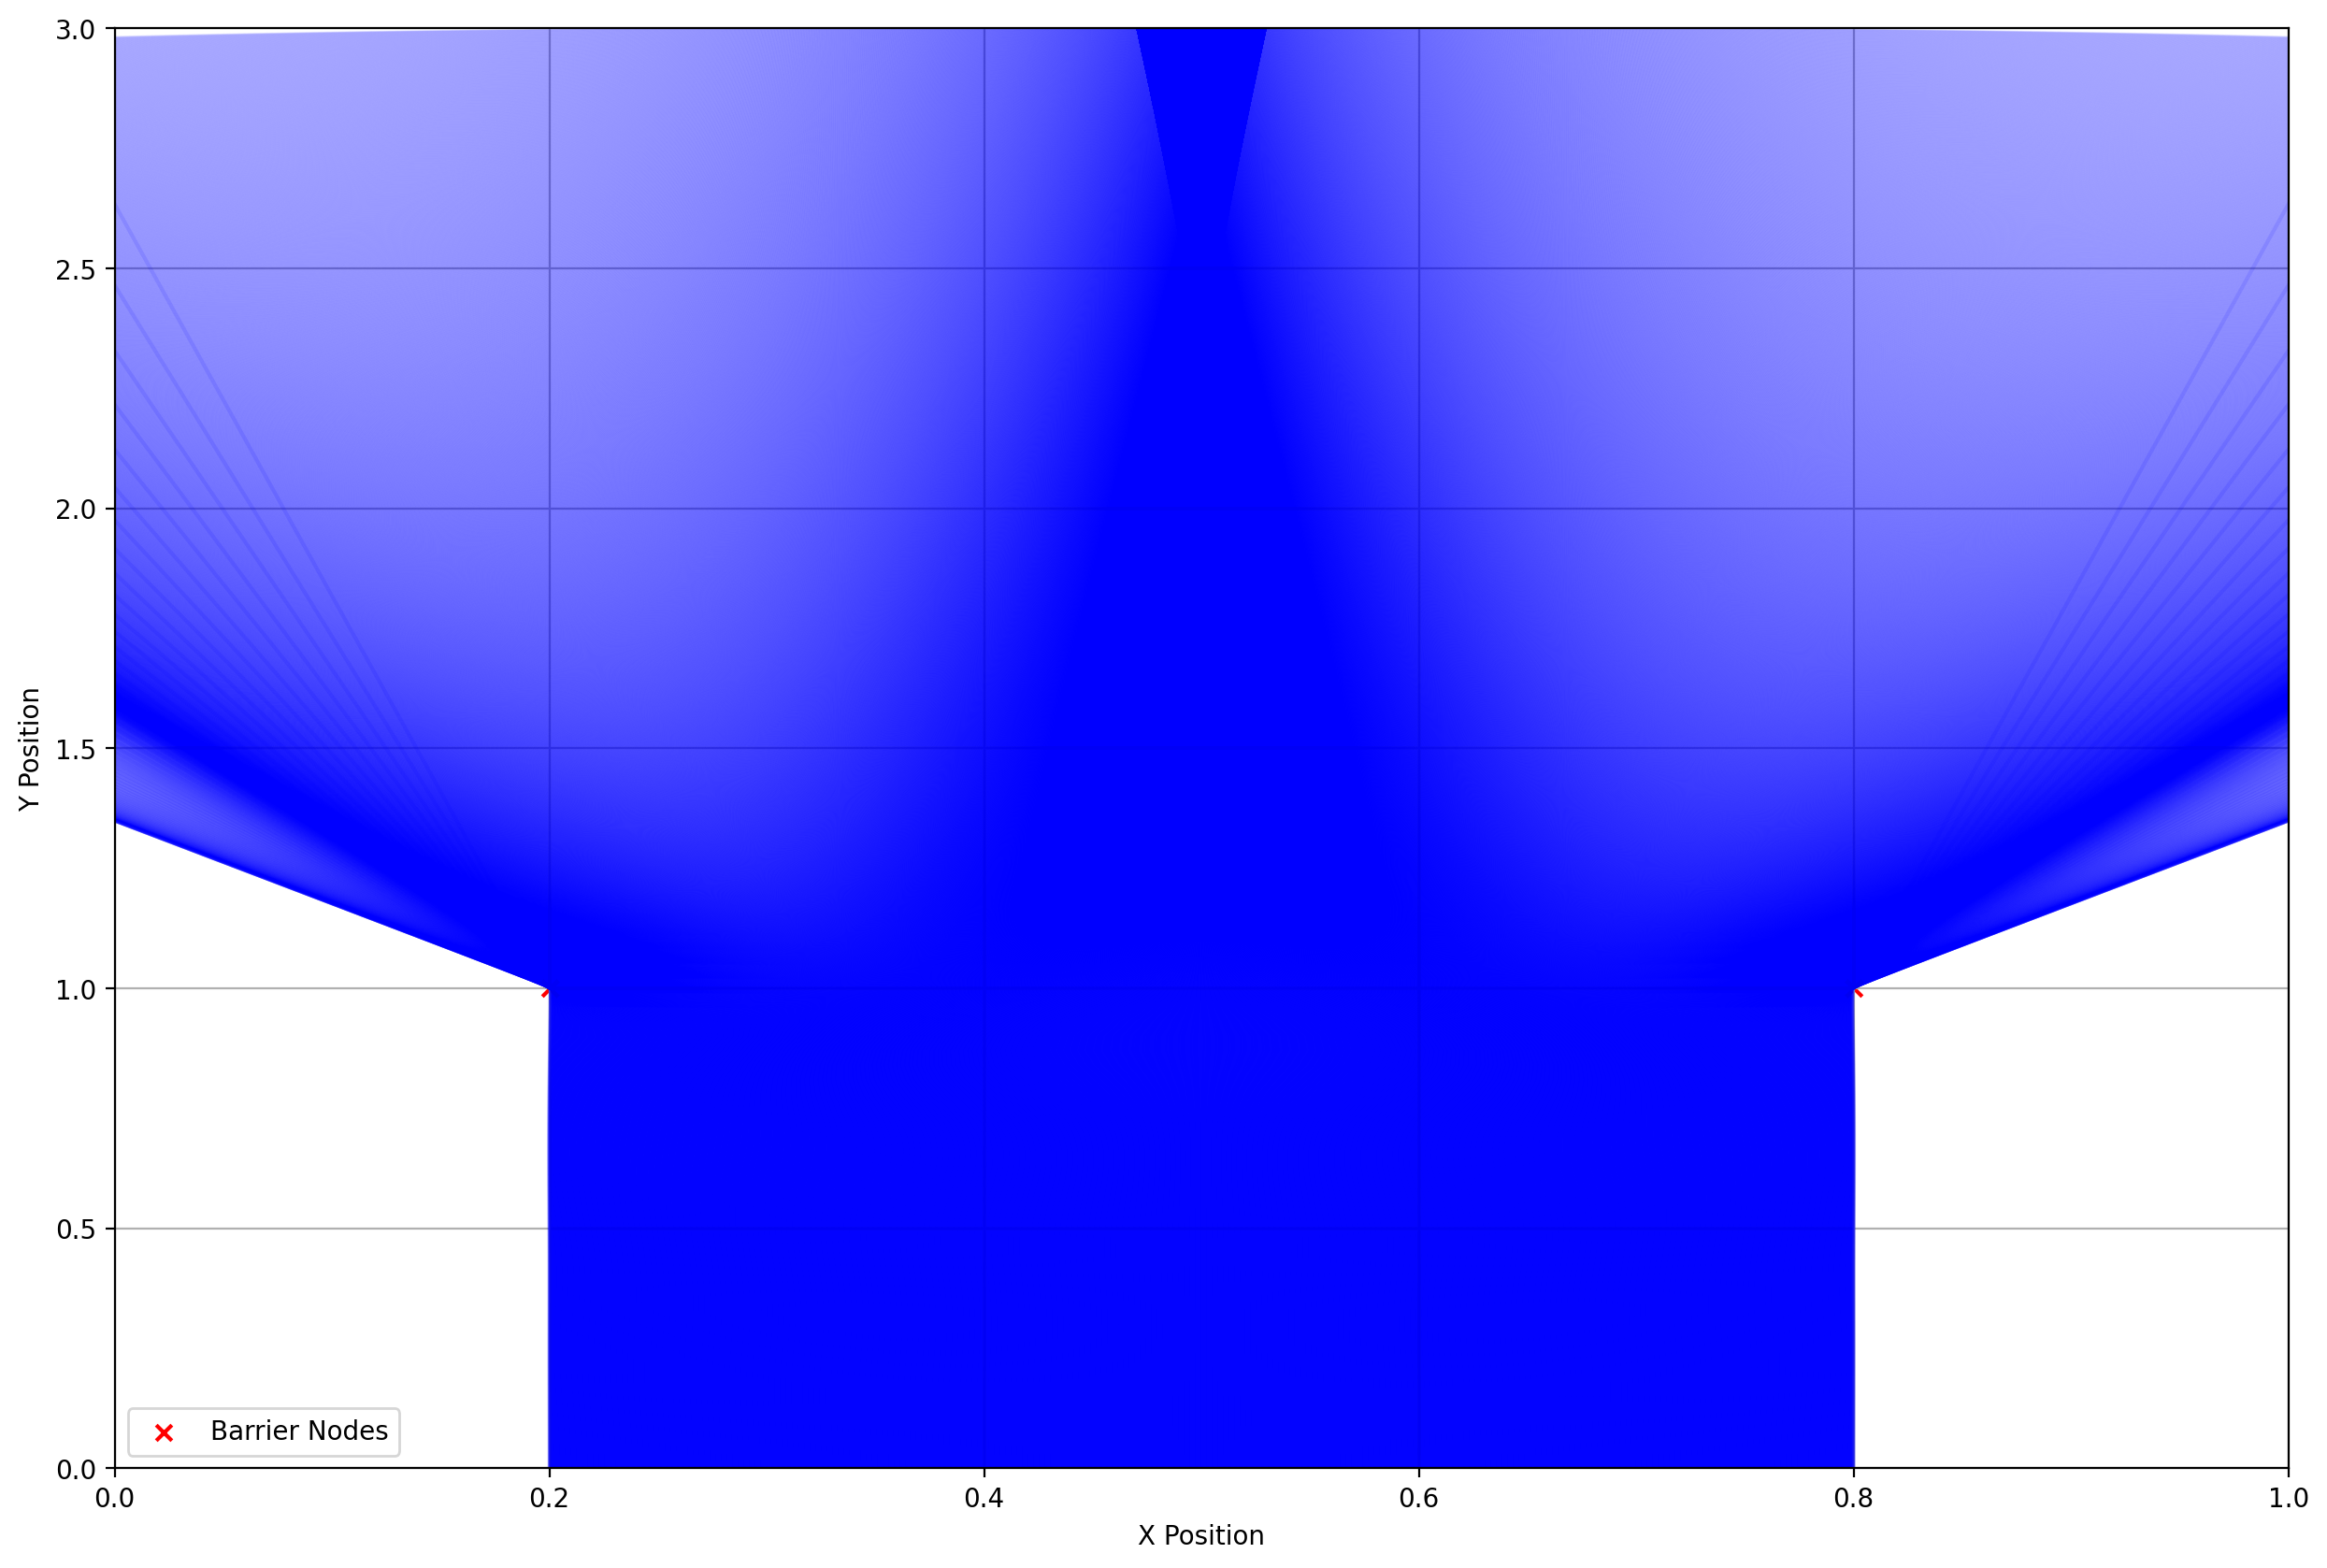

In [727]:
# Visualize the paths of particles
plt.figure(figsize=(15, 10))
for i in tqdm(range(num_particles)):
    plt.plot(
        particle_positions_history[:, i, 0],
        particle_positions_history[:, i, 1],
        color="blue",
        alpha=0.1,
        # label="particle",
    )
plt.scatter(
    barrier_nodes_x,
    np.full_like(barrier_nodes_x, barrier_y),
    c="red",
    marker="x",
    label="Barrier Nodes",
)

# limit x range to 0 to 2
plt.xlim(0, x_range)
plt.ylim(0, initial_velocity_magnitude * total_time)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
# plt.title("Paths of Particles Under Distorted Gravitational Force")
plt.grid(True)
plt.show()

In [ ]:
# Given H, x_edges, y_edges from np.histogram2d

# Calculate how many y-bins to include in each subplot
y_step = len(H) // 40


# Initialize the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop over each subplot to plot the data for different y-values
for i, ax in enumerate(axes):
    start_index = i * y_step
    end_index = start_index + y_step
    
    # Average over multiple y-bins to get a more stable histogram for each subplot
    avg_histogram_values = np.mean(H[start_index:end_index, :], axis=0)
    
    # Plot the histogram
    ax.bar(x_edges[:-1], avg_histogram_values, width=np.diff(x_edges), align="edge", label=f'Y = {y_edges[start_index]} to {y_edges[end_index]}')
    # ax.axvline(1, color='black', linewidth=1)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Parameters
y_values = np.linspace(0, max_y, 40).astype(int)

# Initialize the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop over each subplot to plot the data for different y-values
for i, y in enumerate(y_values):
    ax = axes[i]
    
    # Find the closest y-position in the data
    closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)
    
    # Extract the corresponding x-positions
    x_positions_at_y = np.array([particle_positions_history[closest_y_index[j], j, 0] for j in range(num_particles)])
    
    # Plot the histogram
    ax.hist(particle_positions_history[-1][:, 0], bins=100, density=False, range=(0-1, x_range+1), label=f'Y = {y}')
    ax.axvline(1, color='black', linewidth=1)
    # ax.set_xlabel('x')
    # ax.set_ylabel('Density')
    # hide legend
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y = max_y  # The y-position of the screen
# Extract the particle positions at y = -3 or the closest to it
closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)

# Extract the corresponding x-positions
x_positions_at_y_minus_3 = np.array([particle_positions_history[closest_y_index[i], i, 0] for i in range(num_particles)])

# Plot the distribution of particle positions at y = -3
plt.figure(figsize=(10, 5))
# histogram bins equally spaced between 0 and x_range but with a line distribution instead of bar
plt.hist(x_positions_at_y_minus_3, bins=100, density=False, alpha=0.7, range=(0, x_range), label='Final Distribution of Particles')
# create vertical black line at x = 1
plt.axvline(1, color='black', linewidth=1)
plt.xlabel('x')
plt.ylabel('density')
# plt.title(f'Distribution of Particle Positions at Y = {y}')
plt.grid(True)
plt.show()


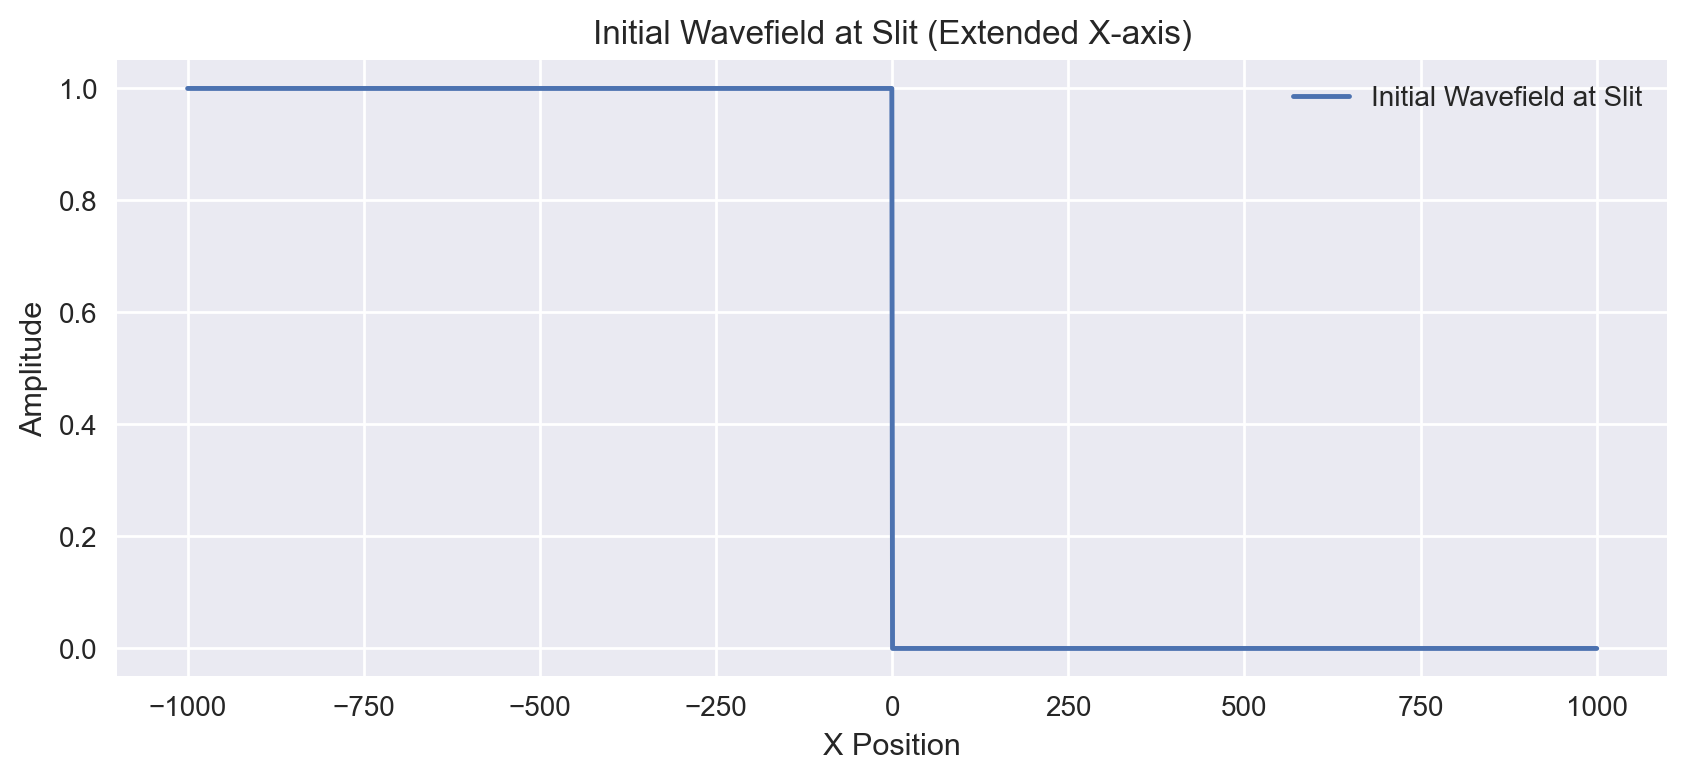

In [355]:
# Define parameters to mimic the setup of the Newtonian gravity experiment but with a 10x smaller slit
slit_width = 0  # From -10 to 10
wavelength = 0.06238
y_steps = np.linspace(1, 1000, 100)  # Screens at y=1 to y=1000

x_values_extended = np.linspace(-1000, 1000, 2000)

# Update the initial wavefield with the new x-axis range
initial_wavefield_extended = np.ones_like(x_values_extended)
# initial_wavefield_extended[np.abs(x_values_extended) > slit_width / 2] = 0
initial_wavefield_extended[x_values_extended > slit_width / 2] = 0

# Plot the updated initial wavefield at the slit
plt.figure(figsize=(10, 4))
plt.plot(x_values_extended, initial_wavefield_extended, label='Initial Wavefield at Slit')
plt.xlabel('X Position')
plt.ylabel('Amplitude')
plt.title('Initial Wavefield at Slit (Extended X-axis)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Function to implement the Rayleigh-Sommerfeld propagation algorithm
def rayleigh_sommerfeld_propagation(initial_wavefield, x_values, y, wavelength):
    dx = x_values[1] - x_values[0]  # step size in x
    propagated_wavefield = np.zeros_like(initial_wavefield, dtype=complex)

    for i, x in tqdm(enumerate(x_values)):
        integral = 0
        for j, x_prime in enumerate(x_values):
            r = np.sqrt((x - x_prime) ** 2 + y**2)
            phase = cmath.exp(1j * 2 * np.pi / wavelength * r)
            integral += initial_wavefield[j] * phase / r * dx
        propagated_wavefield[i] = integral * y / (1j * wavelength)

    return np.abs(propagated_wavefield) ** 2  # return intensity


# Initialize an array to store the wavefield at each screen (y position)
wavefield_3D = []

# Calculate the wavefield at each y step
for y in tqdm(y_steps):
    propagated_wavefield = rayleigh_sommerfeld_propagation(
        initial_wavefield_extended, x_values_extended, y, wavelength
    )
    wavefield_3D.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D = np.array(wavefield_3D)

2000it [00:05, 358.96it/s]


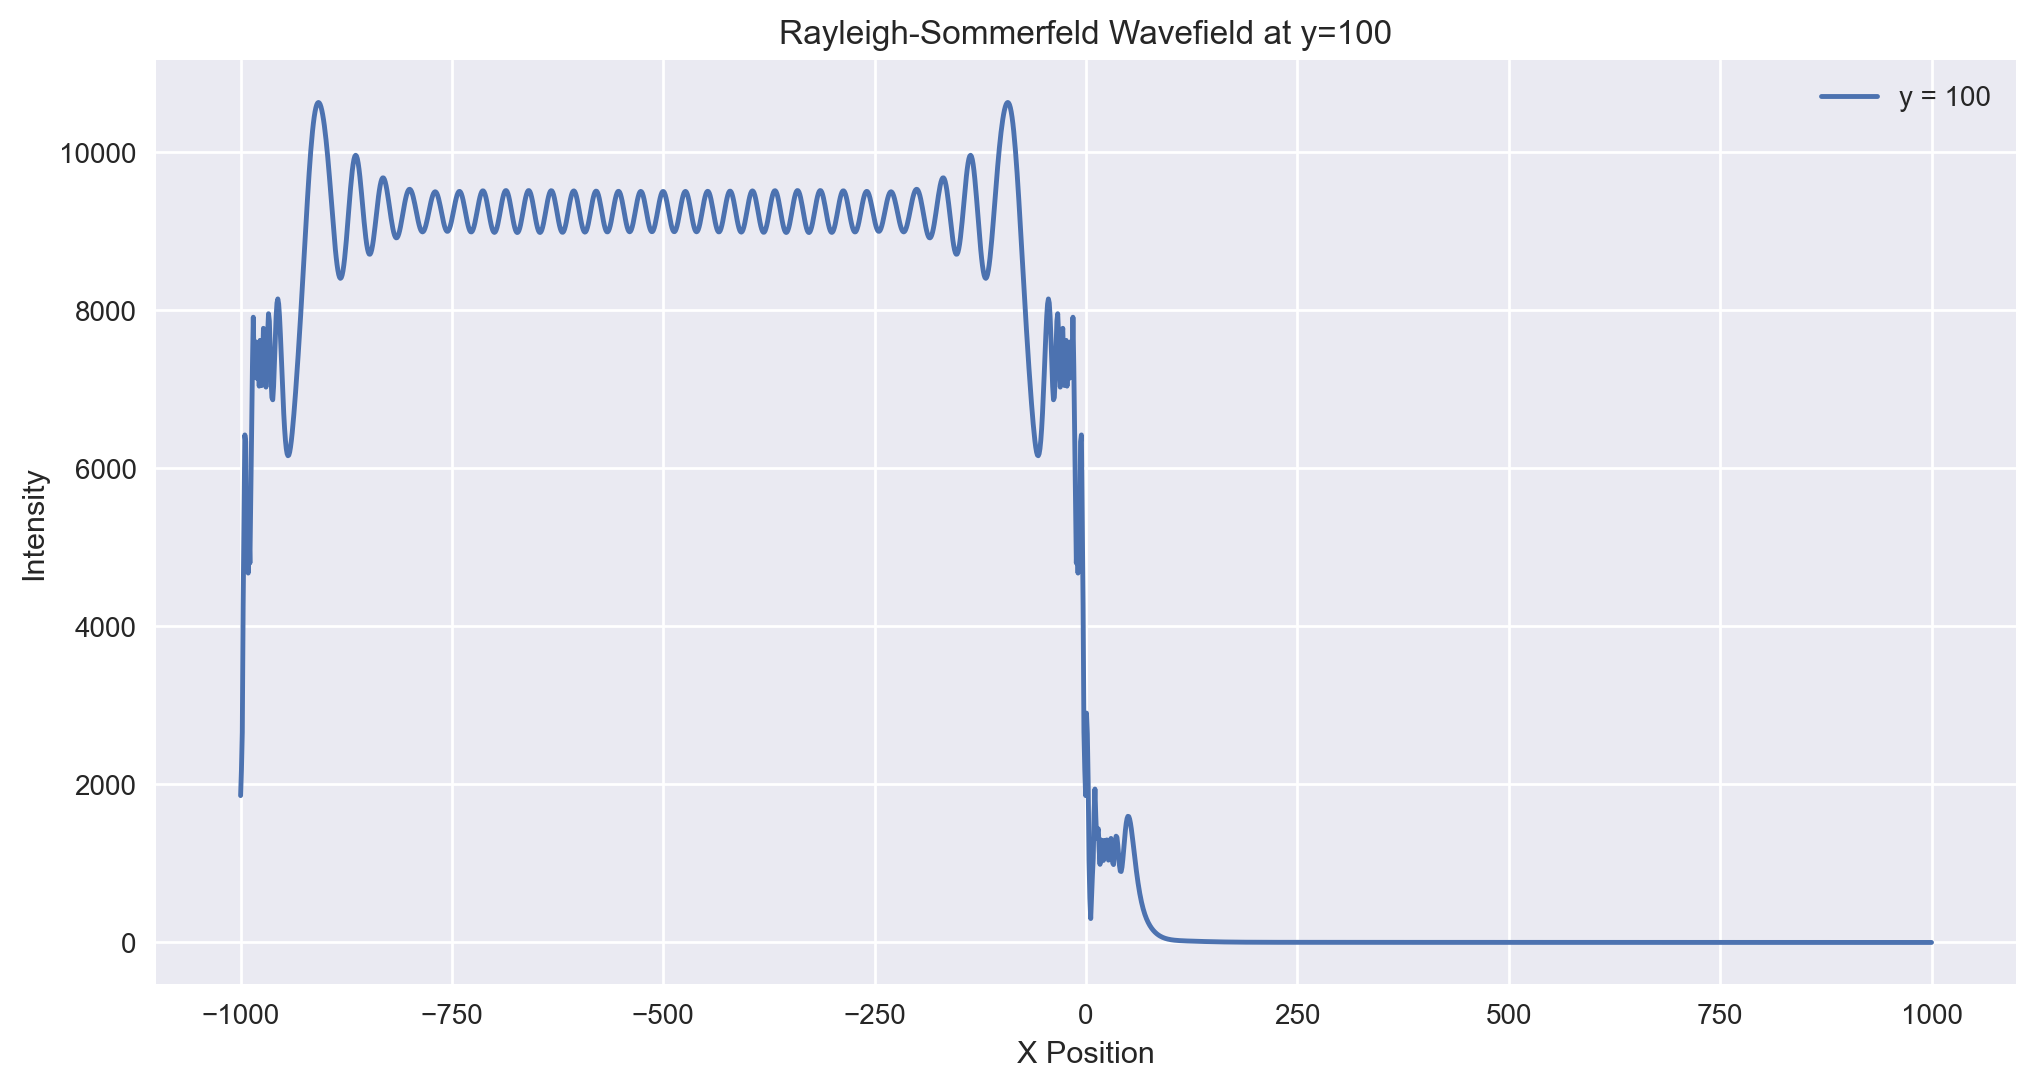

In [357]:
# Calculate the wavefield at y=100 using the Rayleigh-Sommerfeld model
wavefield_y100_RS = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, 5, wavelength)

# Plot the wavefield at y=100 using the Rayleigh-Sommerfeld model
plt.figure(figsize=(12, 6))
plt.plot(x_values_extended, wavefield_y100_RS, label=f'y = 100')
plt.xlabel('X Position')
plt.ylabel('Intensity')
plt.title('Rayleigh-Sommerfeld Wavefield at y=100')
plt.legend()
plt.show()


100%|██████████| 101/101 [00:35<00:00,  2.88it/s]


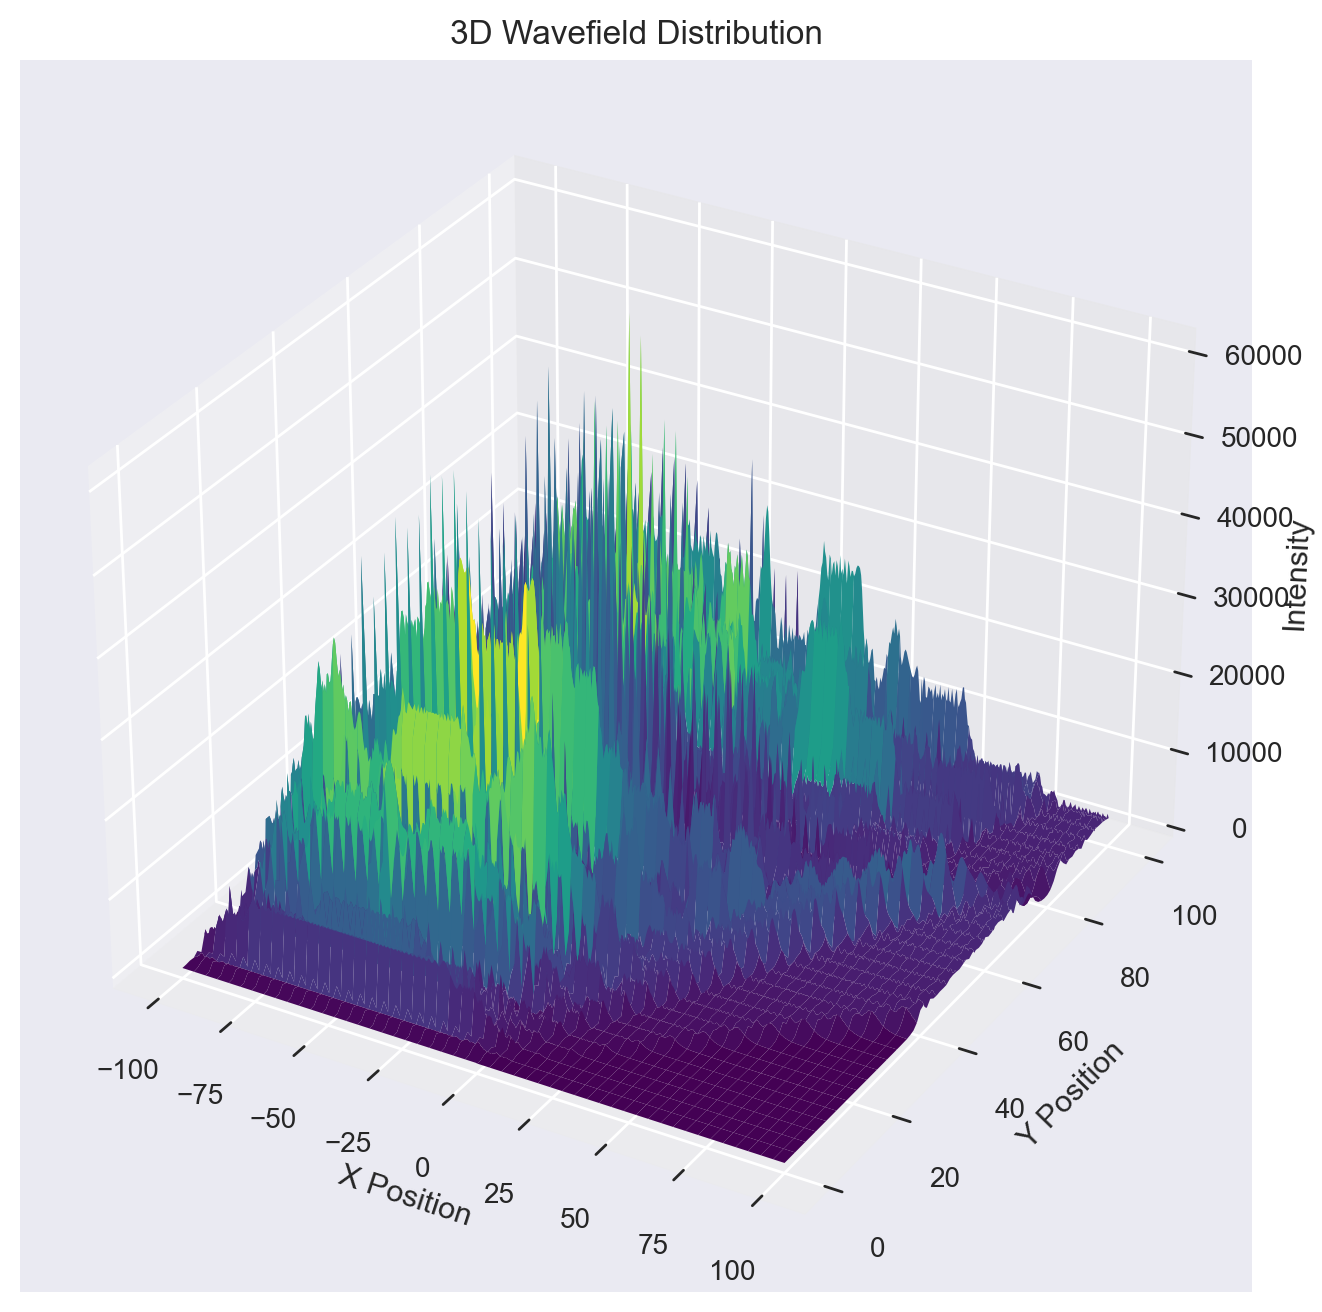

In [342]:
# Define a new range of y-values from 10 to 1000, in steps of 50
y_steps_long = np.arange(0.001, 101, 1)

# Initialize an array to store the wavefield at each screen (y position) for the longer range
wavefield_3D_long = []

# Calculate the wavefield at each y step in the longer range using the Rayleigh-Sommerfeld model
for y in tqdm(y_steps_long):
    propagated_wavefield = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, y, wavelength)
    wavefield_3D_long.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D_long = np.array(wavefield_3D_long)

# Create a 3D plot for the calculated wavefield
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(x_values_extended, y_steps_long)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, wavefield_3D_long, cmap='viridis')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Intensity')
ax.set_title('3D Wavefield Distribution')
plt.show()
